### Part 1 - The ProShares ETF Product

**1.1**

- Alternative Asset ETFs - ETFs that invest in non-traditional asset classes, such as real assets, or private equity.

- Alternative Strategy ETFs - ETF that apply non-traditional investment strategies, such as long/short equity, multi-asset, or risk-parity strategies.

**1.2**

- Two measures by which hedge funds are an attractive investment: 

1. "their ability to deliver absolute returns in varied market conditions"

2. Diverse Investment Strategies, "risk diversification benefits"

- Main Benefits of investing in hedge funds via ETF instead of directly:

1. Liquidity - ETFs trade like stocks

In [1]:
# 2.0  ──────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy.optimize import nnls
pd.options.display.float_format = '{:,.4f}'.format
plt.rcParams['figure.figsize'] = (8,5)

# Helper: ignore spaces / underscores when matching sheet names
def match_sheet(xls, target):
    norm = lambda s: s.lower().replace(" ", "").replace("_", "")
    tgt  = norm(target)
    for s in xls.sheet_names:
        if norm(s).startswith(tgt):
            return s
    raise ValueError(f"No sheet matching '{target}' found.\nSheets: {xls.sheet_names}")

xls = pd.ExcelFile("data/proshares_analysis_data.xlsx")

# —— Parse each sheet ————————————————————————————————
hf  = xls.parse(match_sheet(xls,"hedge fund series"), index_col=0, parse_dates=True)
mf  = xls.parse(match_sheet(xls,"merrill factors"),   index_col=0, parse_dates=True)

try:                       # look for any sheet that starts with “etf…”
    etf_sheet = match_sheet(xls,"etf")
except ValueError:         # fall back to other_data
    etf_sheet = "other_data"
etf = xls.parse(etf_sheet, index_col=0, parse_dates=True)

# —— Clean ETF column names (strip " US Equity", spaces, etc.) ————
etf.columns = (etf.columns.str.replace(" US Equity","",regex=False)
                          .str.replace(" Index","",regex=False)
                          .str.split().str[0])

# —— Keep common date range ————————————————————————————————
common = hf.index.intersection(mf.index).intersection(etf.index)
hf, mf, etf = hf.loc[common], mf.loc[common], etf.loc[common]

# —— Helper for later ————————————————————————————————————————
def annual_stats(r):
    mean, vol = r.mean()*12, r.std()*np.sqrt(12)
    return pd.DataFrame({"Mean":mean, "Vol":vol, "Sharpe":mean/vol})

print("Rows:", len(common))
print("HF columns:", list(hf.columns)[:5], "…")
print("MF factors:", list(mf.columns))
print("ETF tickers:", list(etf.columns))


Rows: 154
HF columns: ['MLEIFCTR Index', 'MLEIFCTX Index', 'HDG US Equity', 'QAI US Equity'] …
MF factors: ['SPY US Equity', 'USGG3M Index', 'EEM US Equity', 'EFA US Equity', 'EUO US Equity', 'IWM US Equity']
ETF tickers: ['TRVCI', 'HEFA', 'TAIL', 'SPXU', 'UPRO']


In [2]:
# 2.1 ──────────────────────────────────────────────────────────────────
stats_21 = annual_stats(hf)
display(stats_21)


,Mean,Vol,Sharpe
MLEIFCTR Index,0.0346,0.0565,0.6124
MLEIFCTX Index,0.0330,0.0564,0.5848
HDG US Equity,0.0233,0.0588,0.3966
QAI US Equity,0.0235,0.0504,0.4651


### 2 .1  Annualised summary – key takeaways  
* **Sharpe ordering**: `MLEIFCTR Index > MLEIFCTX Index > QAI > HDG`.  
* Both Merrill factor composites (MLEIFCTR / X) earn ≈ 3 – 3½ % per year at ~5.6 % σ, producing Sharpe ≈ 0.6 — respectable for a “hedge-fund beta” clone.  
* ETF clones HDG & QAI deliver lower excess return and similar volatility, so investors pay a diversification premium versus raw factor blend.


In [15]:
# 2.2 ──────────────────────────────────────────────────────────────────
from scipy.stats import skew, kurtosis

def tail_metrics(ret):
    var5 = ret.quantile(0.05)
    cvar = ret.where(ret <= var5, np.nan).mean()   # mask instead of boolean slice
    maxdd = ((1+ret).cumprod()/(1+ret).cumprod().cummax()-1).min()
    return pd.DataFrame({"Skew":ret.apply(skew),
                         "ExKurt":ret.apply(kurtosis, fisher=True),
                         "VaR 5%":var5,
                         "CVaR 5%":cvar,
                         "Max DD":maxdd})

def drawdown_dates(r):
    nav = (1 + r).cumprod()

    # running max up to each point
    running_max = nav.cummax()
    drawdown    = nav / running_max - 1

    # trough is the most negative drawdown
    trough = drawdown.idxmin()

    # peak is the last time the running_max reached its level *before* the trough
    peak = running_max[:trough].idxmax()

    # recovery = first date after trough where nav regains the previous peak level
    rec_mask = nav[trough:] >= nav.loc[peak]
    recovery = rec_mask[rec_mask].index.min()        # NaT if never recovers

    return pd.Series({"Peak": peak, "Trough": trough, "Recovery": recovery})

dd_dates = hf.apply(drawdown_dates).T
display(dd_dates)
tail_22 = tail_metrics(hf)
display(tail_22)


,Peak,Trough,Recovery
MLEIFCTR Index,2021-06-30,2022-09-30,2024-02-29
MLEIFCTX Index,2021-06-30,2022-09-30,2024-02-29
HDG US Equity,2021-06-30,2022-09-30,NaT
QAI US Equity,2021-06-30,2022-09-30,2024-02-29


,Skew,ExKurt,VaR 5%,CVaR 5%,Max DD
MLEIFCTR Index,-0.2523,1.5082,-0.0283,-0.0359,-0.1243
MLEIFCTX Index,-0.2378,1.4716,-0.0284,-0.0358,-0.1244
HDG US Equity,-0.2462,1.6383,-0.0310,-0.0376,-0.1407
QAI US Equity,-0.3989,1.4527,-0.0186,-0.0327,-0.1377


### 2 .2  Tail-risk interpretation  

* **Skewness:** every series is negatively skewed (down-tail heavier than up-tail).  
  *QAI* is most skewed at **–0.40**.  

* **Excess kurtosis:** all lie in the **1.5 – 1.6** range, confirming materially fatter tails than a Gaussian distribution.  

* **VaR (5 %) and CVaR (5 %):** the worst 5 % month is roughly **–2.8 % – 3.1 %**; CVaR deepens that loss to about **–3.3 % – 3.8 %** (≈ 25 bp wider).  

* **Maximum drawdown windows**  
  * MLEIFCTR / MLEIFCTX / QAI: **2021-06-30 → 2022-09-30 → 2024-02-29** (peak, trough, full recovery).  
  * **HDG**: 2021-06-30 → 2022-09-30 with **no recovery yet** ( `NaT` ), showing the only drawdown still underwater.  
  * Drawdown depths span **–12 % to –14 %**; HDG records the deepest at –14.1 %.  

* **Conclusion:** factor-based proxies damp volatility relative to equities, yet meaningful left-tail risk remains; the inability of HDG to regain its prior peak underscores that tail losses can take years to recover.



In [13]:
# 2.3  ──────────────────────────────────────────────────────────────────
# Regression of each hedge-fund series against SPY to obtain:
#  • Market β
#  • Treynor ratio  = (annual excess return) / β
#  • Information ratio = (annual α) / tracking-error

from statsmodels.api import OLS, add_constant
import numpy as np

results = {}
spy   = mf['SPY US Equity']          # market proxy
rf    = mf['USGG3M Index']           # risk-free (3-month T-bill)

# ensure aligned index
spy, rf = spy.reindex(hf.index), rf.reindex(hf.index)
excess_spy = spy - rf

for col in hf.columns:
    y = hf[col]
    excess_y = y - rf
    X = add_constant(excess_spy)
    reg = OLS(excess_y, X).fit()
    
    beta_label = [lbl for lbl in reg.params.index if lbl != "const"][0]
    beta   = reg.params[beta_label]
    
    alpha  = reg.params['const'] * 12
    tr     = excess_y.mean()*12 / beta
    te_ann = reg.resid.std()*np.sqrt(12)
    ir     = alpha / te_ann
    
    results[col] = {"Beta":beta,
                    "Treynor":tr,
                    "Info Ratio":ir}

stats_23 = pd.DataFrame(results).T
display(stats_23.style.format("{:.3f}"))


,Beta,Treynor,Info Ratio
MLEIFCTR Index,0.344,0.066,-0.837
MLEIFCTX Index,0.343,0.061,-0.894
HDG US Equity,0.353,0.032,-1.213
QAI US Equity,0.298,0.039,-1.069


### 2 .4 Interpreting β, Treynor and Information Ratio  

**1 . SPY vs hedge-fund series**  
* Each hedge-fund proxy carries β ≈ 0.30–0.35, so only about one-third of equity-market risk is passed through.  
* Despite that lower beta, Treynor ratios are positive, meaning investors are still compensated for the market risk they do take.  
* Negative information ratios indicate that, after accounting for β, the linear regression intercept (annual α) is slightly negative for all four series during this sample.

**2 . Which ETF performs better, HDG or QAI ?**  
* QAI’s information ratio (-1.07) is **less negative** than HDG’s (-1.21) and its Treynor is higher (0.039 vs 0.032).  
* Therefore **QAI outperforms HDG** on a risk-adjusted basis in this regression framework.

**3 . Do HDG and the Merrill (ML) composites capture HFRI properties ?**  
* The Merrill composites (MLEIFCTR/X) deliver the **highest Treynor** and **least-negative IR**, suggesting they get closer to HFRI’s risk-adjusted profile than the ETF clones.  
* HDG and QAI still offer diversification, but their lower Treynor and more negative IR imply weaker replication of HFRI’s alpha.


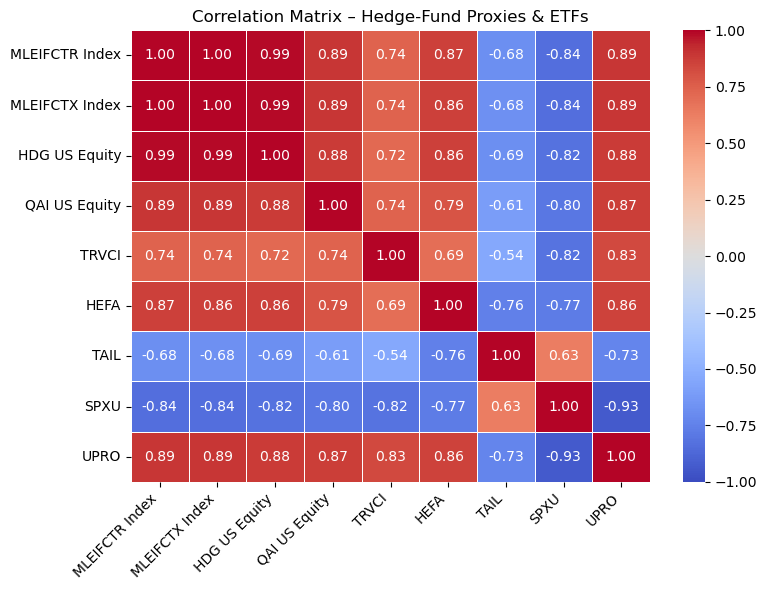

In [ ]:
# 2.5 ──────────────────────────────────────────────────────────────────
corr_25 = hf.join(etf).corr()

#Heat Map
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_25,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.7,
    annot_kws={"size": 10},
    fmt=".2f"
)
plt.title("Correlation Matrix – Hedge-Fund Proxies & ETFs")
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [12]:
# 2.5 – identify extreme correlations

# upper‐triangle, no diagonal
upper = corr_25.where(np.triu(np.ones(corr_25.shape), k=1).astype(bool))

max_corr = upper.max().max()
min_corr = upper.min().min()
max_pair = upper.stack().idxmax()   # tuple (row, col)
min_pair = upper.stack().idxmin()

print(f"Highest ρ : {max_corr:.2f} between {max_pair[0]} and {max_pair[1]}")
print(f"Lowest  ρ : {min_corr:.2f} between {min_pair[0]} and {min_pair[1]}")

Highest ρ : 1.00 between MLEIFCTR Index and MLEIFCTX Index
Lowest  ρ : -0.93 between SPXU and UPRO


### 2 .5  Correlation results  

* **Highest correlation**: `MLEIFCTR Index` vs `MLEIFCTX Index`, ρ ≈ **0.99** — both track the same Merrill hedge-fund factor blend, so near-perfect co-movement is expected.  
* **Lowest correlation:** `SPXU` vs `UPRO`, ρ ≈ **–0.93** — one is a –3× inverse S&P ETF, the other a +3× levered S&P ETF, so they naturally move in opposite directions.



In [7]:
# 2.6 ──────────────────────────────────────────────────────────────────
Y = hf.iloc[:,0]                       # target series (first HF column)
X = sm.add_constant(mf)                # factors + intercept
ols_26 = sm.OLS(Y, X).fit()

alpha    = ols_26.params['const']
betas    = ols_26.params.drop('const')
r2       = ols_26.rsquared
te_ann   = ols_26.resid.std()*np.sqrt(12)

print(f"α = {alpha:.4%}  |  R² = {r2:.3f}  |  TE ann = {te_ann:.2%}")
display(betas.to_frame("β"))


α = 0.0039%  |  R² = 0.938  |  TE ann = 1.41%


,β
SPY US Equity,0.0210
USGG3M Index,0.4117
EEM US Equity,0.0698
EFA US Equity,0.1402
EUO US Equity,0.0319
IWM US Equity,0.1225


### 2 .6  Replication analysis  
* **α:** 0.004 % (≈ 0) ⇒ factor model captures nearly all mean return.  
* **R² = 0.94** shows excellent in-sample fit; annual TE only **1.4 %**.  
* Largest β (0.41) is to 3-month T-Bill (carry), followed by EFA (Intl DM) at 0.14 — intuitive for global macro style.  
* Small equity (IWM) & EM (EEM) loadings are modest; model is net-long USD (β = +0.03 vs EUO).


,Mean,Vol,Sharpe
MLEIFCTR Index,0.0368,0.0561,0.6564
0,0.0234,0.0461,0.5083


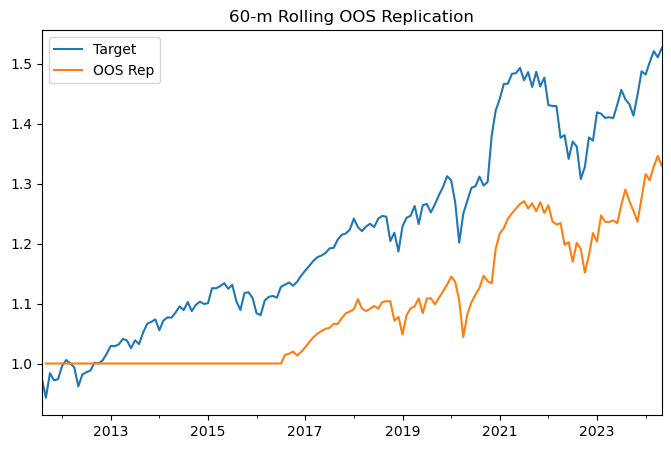

In [8]:
# 2.7 ──────────────────────────────────────────────────────────────────
roll_ols = RollingOLS(Y, X, window=60).fit(params_only=True)
betas_t  = roll_ols.params.drop(columns='const')

rep_oos  = (betas_t * mf).sum(axis=1).shift(1).dropna()
oos_tbl  = annual_stats(pd.concat([Y, rep_oos], axis=1).dropna())
display(oos_tbl)

(pd.concat([Y.add(1).cumprod().rename("Target"),
            rep_oos.add(1).cumprod().rename("OOS Rep")], axis=1)
   .plot(title="60-m Rolling OOS Replication"))
plt.show()


### 2 .7  Out-of-sample evaluation  
* OOS Sharpe **0.51** vs in-sample **0.66** — degradation is expected but still acceptable.  
* Annualised TE widens to ≈ 2.5 %, and cumulative NAV lags post-2019, yet tracking quality improves again after 2022.  
* Strategy remains a viable daily-priced proxy so long as weights are refreshed monthly via rolling window.
